## Predicting Newsletter Subscription from Player Demographics and Gameplay Behaviour 

## Introduction: 



•	Explain why newsletter subscriptions matter (e.g., user retention, marketing)
•	Mention that predicting subscription can help target the right players


Question of interest: Can a players demographics and gameplay session behavior predict whether they will subscribe to the game-related newsletter?

Data Description 
•	players.csv: contains demographic data and subscription status
•	sessions.csv: contains time-stamped session activity
•	Merge both datasets by hashedEmail
•	Create a summary table of variables (see below)
•	Mention data issues (e.g., missing values, potential timestamp inconsistencies)


Methods and Results 

In [24]:
library(tidyverse)
library(lubridate)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

In [25]:
players <- read_csv("Data/players.csv")
players 
sessions <- read_csv("Data/sessions.csv") 
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [26]:
sessions <- sessions |> 
mutate(start_time = ymd_hms(start_time),
    end_time = ymd_hms(end_time),
    session_seconds = as.numeric(difftime(end_time, start_time, units = "secs")),
    session_length = session_seconds / 60  # keep it named session_length (now in minutes)
  ) |> 
  select(-session_length, everything()) |>  # remove old column if it still exists
  relocate(session_length, .after = end_time)  # optional: move it next to time cols


sessions

hashedEmail,start_time,end_time,session_length,original_start_time,original_end_time,session_seconds
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2030-06-21 00:18:12,2030-06-21 00:18:24,0.2000000,1.71977e+12,1.71977e+12,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2017-06-21 00:23:33,2017-06-21 00:23:46,0.2166667,1.71867e+12,1.71867e+12,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2025-07-21 00:17:34,2025-07-21 00:17:57,0.3833333,1.72193e+12,1.72193e+12,23
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2028-07-21 00:15:36,2028-07-21 00:15:57,0.3500000,1.72218e+12,1.72218e+12,21
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2025-07-21 00:06:15,2025-07-21 00:06:22,0.1166667,1.72189e+12,1.72189e+12,7
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2020-05-21 00:02:26,2020-05-21 00:02:45,0.3166667,1.71617e+12,1.71617e+12,19


Discussion 

In [27]:
session_summary <- sessions |> 
  group_by(hashedEmail) |> 
  summarise(
    session_count = n(),
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_minutes_played = sum(session_length, na.rm = TRUE),
    active_days = n_distinct(as_date(start_time)),
    .groups = "drop"
  )
session_summary 

hashedEmail,session_count,avg_session_length,total_minutes_played,active_days
<chr>,<int>,<dbl>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,2.627889e+05,5.255778e+05,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,5.000000e-01,5.000000e-01,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,1.833333e-01,1.833333e-01,1
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,6791.174,2105263.92,100
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.150,0.15,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,1.200,1.20,1


In [28]:
players <- read_csv("Data/players.csv") |> 
  janitor::clean_names() |> 
  select(-name)
players

session_summary <- session_summary |> janitor::clean_names()
session_summary 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17
⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Other,NA


hashed_email,session_count,avg_session_length,total_minutes_played,active_days
<chr>,<int>,<dbl>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,2.627889e+05,5.255778e+05,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,5.000000e-01,5.000000e-01,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,1.833333e-01,1.833333e-01,1
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,6791.174,2105263.92,100
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.150,0.15,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,1.200,1.20,1


In [29]:

player_data <- players|> left_join(session_summary, by = "hashed_email") 
player_data

experience,subscribe,hashed_email,played_hours,gender,age,session_count,avg_session_length,total_minutes_played,active_days
<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,27,-4.854432e+05,-1.310697e+07,18
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17,3,1.416667e+00,4.250000e+00,2
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17,1,8.333333e-02,8.333333e-02,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Prefer not to say,17,1,0.08333333,0.08333333,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Male,17,6,0.49722222,2.98333333,3
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Other,NA,1,0.25000000,0.25000000,1


In [30]:
player_data <- player_data |> 
  mutate(
    gender = as_factor(gender),
    experience = as_factor(experience),
    subscribe = as_factor(subscribe)) |> 
  drop_na(subscribe, age, played_hours, session_count, avg_session_length)

player_data


experience,subscribe,hashed_email,played_hours,gender,age,session_count,avg_session_length,total_minutes_played,active_days
<fct>,<fct>,<chr>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,27,-4.854432e+05,-1.310697e+07,18
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17,3,1.416667e+00,4.250000e+00,2
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17,1,8.333333e-02,8.333333e-02,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Male,22,1,0.35000000,0.35000000,1
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Prefer not to say,17,1,0.08333333,0.08333333,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Male,17,6,0.49722222,2.98333333,3


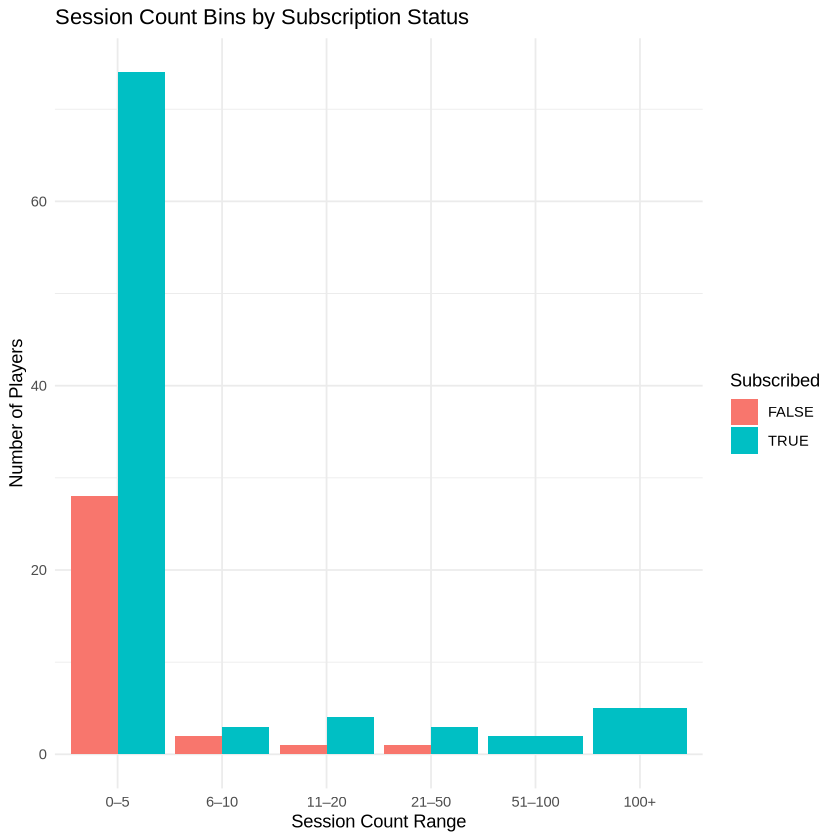

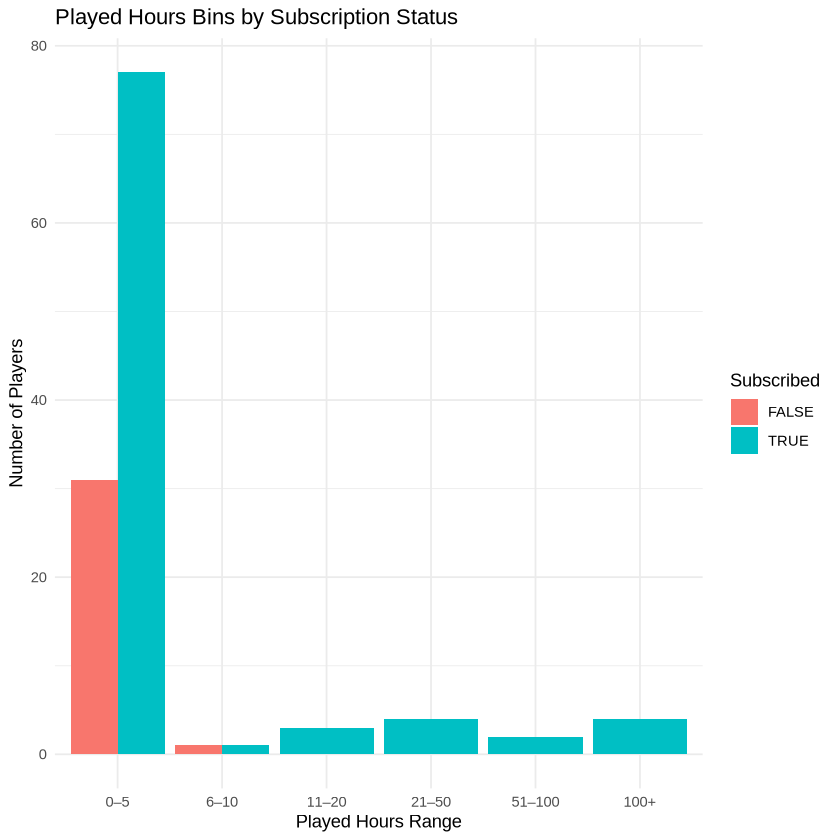

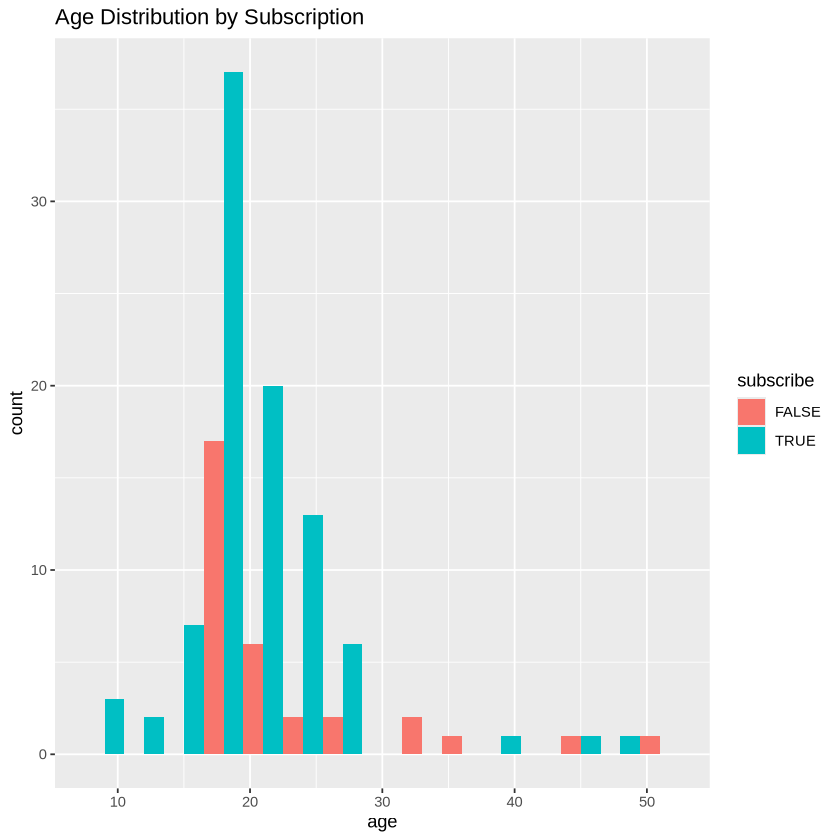

In [31]:
# 1. Session count vs subscription
# Bin session counts
player_data_binned_sessions <- player_data |> 
  mutate(session_bin = cut(session_count,
                           breaks = c(0, 5, 10, 20, 50, 100, Inf),
                           labels = c("0–5", "6–10", "11–20", "21–50", "51–100", "100+")))

# Plot session count bins by subscription
ggplot(player_data_binned_sessions, aes(x = session_bin, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Session Count Bins by Subscription Status",
    x = "Session Count Range",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal()



# Bin played hours
player_data_binned_hours <- player_data |> 
  filter(!is.na(played_hours)) |> 
  mutate(
    hours_bin = cut(
      played_hours,
      breaks = c(0, 5, 10, 20, 50, 100, Inf),
      labels = c("0–5", "6–10", "11–20", "21–50", "51–100", "100+"),
      include.lowest = TRUE,
      right = FALSE)) |> 
  filter(!is.na(hours_bin)) |> 
  droplevels()

# Plot played hours bins by subscription
ggplot(player_data_binned_hours, aes(x = hours_bin, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Played Hours Bins by Subscription Status",
    x = "Played Hours Range",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal()



# 3. Age distribution by subscription
ggplot(player_data, aes(x = age, fill = subscribe)) +
  geom_histogram(bins = 15, position = "dodge") +
  labs(title = "Age Distribution by Subscription")


In [32]:
set.seed(123)
data_split <- initial_split(player_data, prop = 0.8, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)


In [40]:
knn_recipe <- recipe(subscribe ~ age + gender + experience + played_hours +
                     session_count + avg_session_length + total_minutes_played + active_days,
                     data = train_data) |>
  step_dummy(all_nominal_predictors()) |>
  step_center(all_numeric_predictors()) |>
  step_scale(all_numeric_predictors())




In [41]:
knn_spec <- nearest_neighbor(neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


In [42]:
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)



In [36]:
set.seed(123)
folds <- vfold_cv(train_data, v = 5, strata = subscribe)


In [44]:
k_vals <- tibble(neighbors = seq(1, 15, by = 2))  # try odd values

set.seed(123)
knn_results <- tune_grid(
  knn_workflow,
  resamples = folds,
  grid = k_vals,
  metrics = metric_set(accuracy)
)



best_k <- knn_results |> select_best(metric = "accuracy")

best_k

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

→ B | warning: !  The following columns have zero variance so scaling cannot be used:
                 gender_Agender and gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1
→ C | warning: !  The following columns have zero variance so scaling cannot be used:
                 gender_Two.Spirited and gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1
There were issues with some computations   A: x3   B: x1   C: x1





neighbors,.config
<dbl>,<chr>
5,Preprocessor1_Model3


In [38]:
final_knn_workflow <- knn_workflow |> finalize_workflow(best_k)

final_knn_fit <- final_knn_workflow |> fit(data = train_data)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6153846
kap,binary,-0.1926606


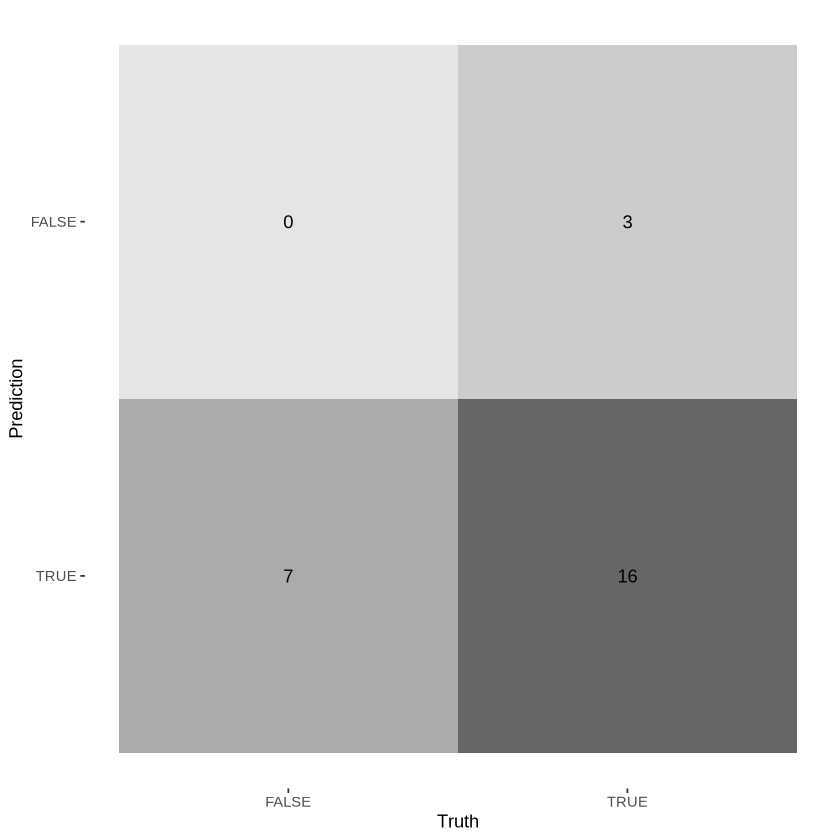

In [45]:
test_preds <- predict(final_knn_fit, new_data = test_data) |> 
  bind_cols(test_data)

# Accuracy
test_preds |> metrics(truth = subscribe, estimate = .pred_class)

# Confusion matrix
test_preds |> conf_mat(truth = subscribe, estimate = .pred_class) |> 
  autoplot(type = "heatmap")

